In [2]:
import itertools
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from matplotlib.axes import Axes
from matplotlib.collections import PathCollection
from matplotlib.colors import Colormap
from matplotlib.figure import Figure, SubFigure
from matplotlib.lines import Line2D
from matplotlib.typing import ColorType, MarkerType
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from src.configs.visualization_configs import FeatureDatetimeCfg
from src.visualization import plot

plot.set_mpl_styles(fontsize=10)

In [3]:
cfg64 = FeatureDatetimeCfg.from_datetime(2025, 1, 23, 16, 14, 36)
cfg32 = FeatureDatetimeCfg.from_datetime(2025, 1, 23, 16, 41, 16)
datetime64 = "2024-12-18/16-56-50"
datetime32 = "2024-12-20/11-18-00"
checkdata64 = pl.read_csv(cfg64.feature_path / "features_check_data.csv")
checkdata32 = pl.read_csv(cfg32.feature_path / "features_check_data.csv")
traindata64 = pl.read_csv(cfg64.feature_path / "features_train_data.csv")
traindata32 = pl.read_csv(cfg32.feature_path / "features_train_data.csv")

In [4]:
# 64x64px
arr64 = checkdata64.select(
    pl.exclude(["target", "prediction", "filename", "dirname"])
).to_numpy()
metacheckdata64 = checkdata64.select(
    pl.exclude(r"^column_\d+$")
).with_row_count("id")
trainarr64 = (
    traindata64.filter(pl.col("target") != -1)
    .select(pl.exclude(["target", "prediction", "filename", "dirname"]))
    .to_numpy()
)

# 32x32px
arr32 = checkdata32.select(
    pl.exclude(["target", "prediction", "filename", "dirname"])
).to_numpy()
metacheckdata32 = checkdata32.select(
    pl.exclude(r"^column_\d+$")
).with_row_count("id")
trainarr32 = (
    traindata32.filter(pl.col("target") != -1)
    .select(pl.exclude(["target", "prediction", "filename", "dirname"]))
    .to_numpy()
)

In [5]:
sc64 = StandardScaler()
pca64 = PCA(random_state=42)
mm64 = MinMaxScaler((-1, 1))
trainarr64_std = sc64.fit_transform(trainarr64)
trainarr64_pca = pca64.fit_transform(trainarr64_std)
trainarr64_mm = mm64.fit_transform(trainarr64_pca)
arr64_std = sc64.transform(arr64)
arr64_pca = pca64.transform(arr64_std)
arr64_mm = mm64.transform(arr64_pca)
arrs64 = {"std": arr64_std, "pca": arr64_pca, "mm": arr64_mm}

sc32 = StandardScaler()
pca32 = PCA(random_state=42)
mm32 = MinMaxScaler((-1, 1))
trainarr32_std = sc32.fit_transform(trainarr32)
trainarr32_pca = pca32.fit_transform(trainarr32_std)
trainarr32_mm = mm32.fit_transform(trainarr32_pca)
arr32_std = sc32.transform(arr32)
arr32_pca = pca32.transform(arr32_std)
arr32_mm = mm32.transform(arr32_pca)
arrs32 = {"std": arr32_std, "pca": arr32_pca, "mm": arr32_mm}

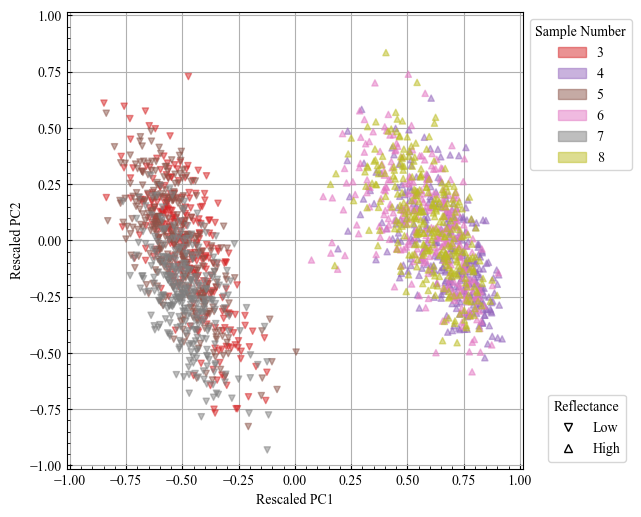

In [5]:
only_train_data = metacheckdata64.filter(pl.col("target") != -1)
idxes = only_train_data.select("id").to_series()
fig = plot.plot_scatter_reflclsf_features(
    arr64_mm,
    only_train_data,
    # metacheckdata64,
    figsize_cm=(16, 16),
    plotting_dims=(0, 1),
    is_pca_data=True,
    is_rescaled_data=True,
    showing_legend=True,
)
# fig.savefig(figdir / datetime64 / "kpca_scatter_4x4cm.svg")

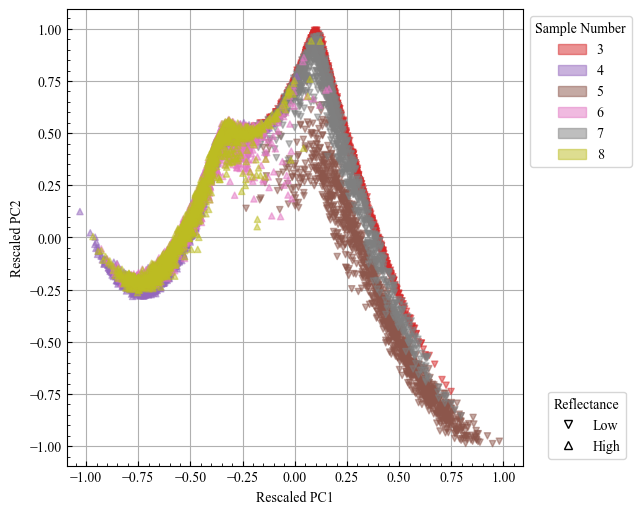

In [6]:
only_train_data = metacheckdata32.filter(pl.col("target") != -1)
idxes = only_train_data.select("id").to_series()
fig = plot.plot_scatter_reflclsf_features(
    arr32_mm,
    only_train_data,
    # metacheckdata32,
    figsize_cm=(16, 16),
    plotting_dims=(0, 1),
    is_pca_data=True,
    is_rescaled_data=True,
    showing_legend=True,
)
# fig.savefig(figdir / datetime32 / "pca_scatter_4x4cm.svg")

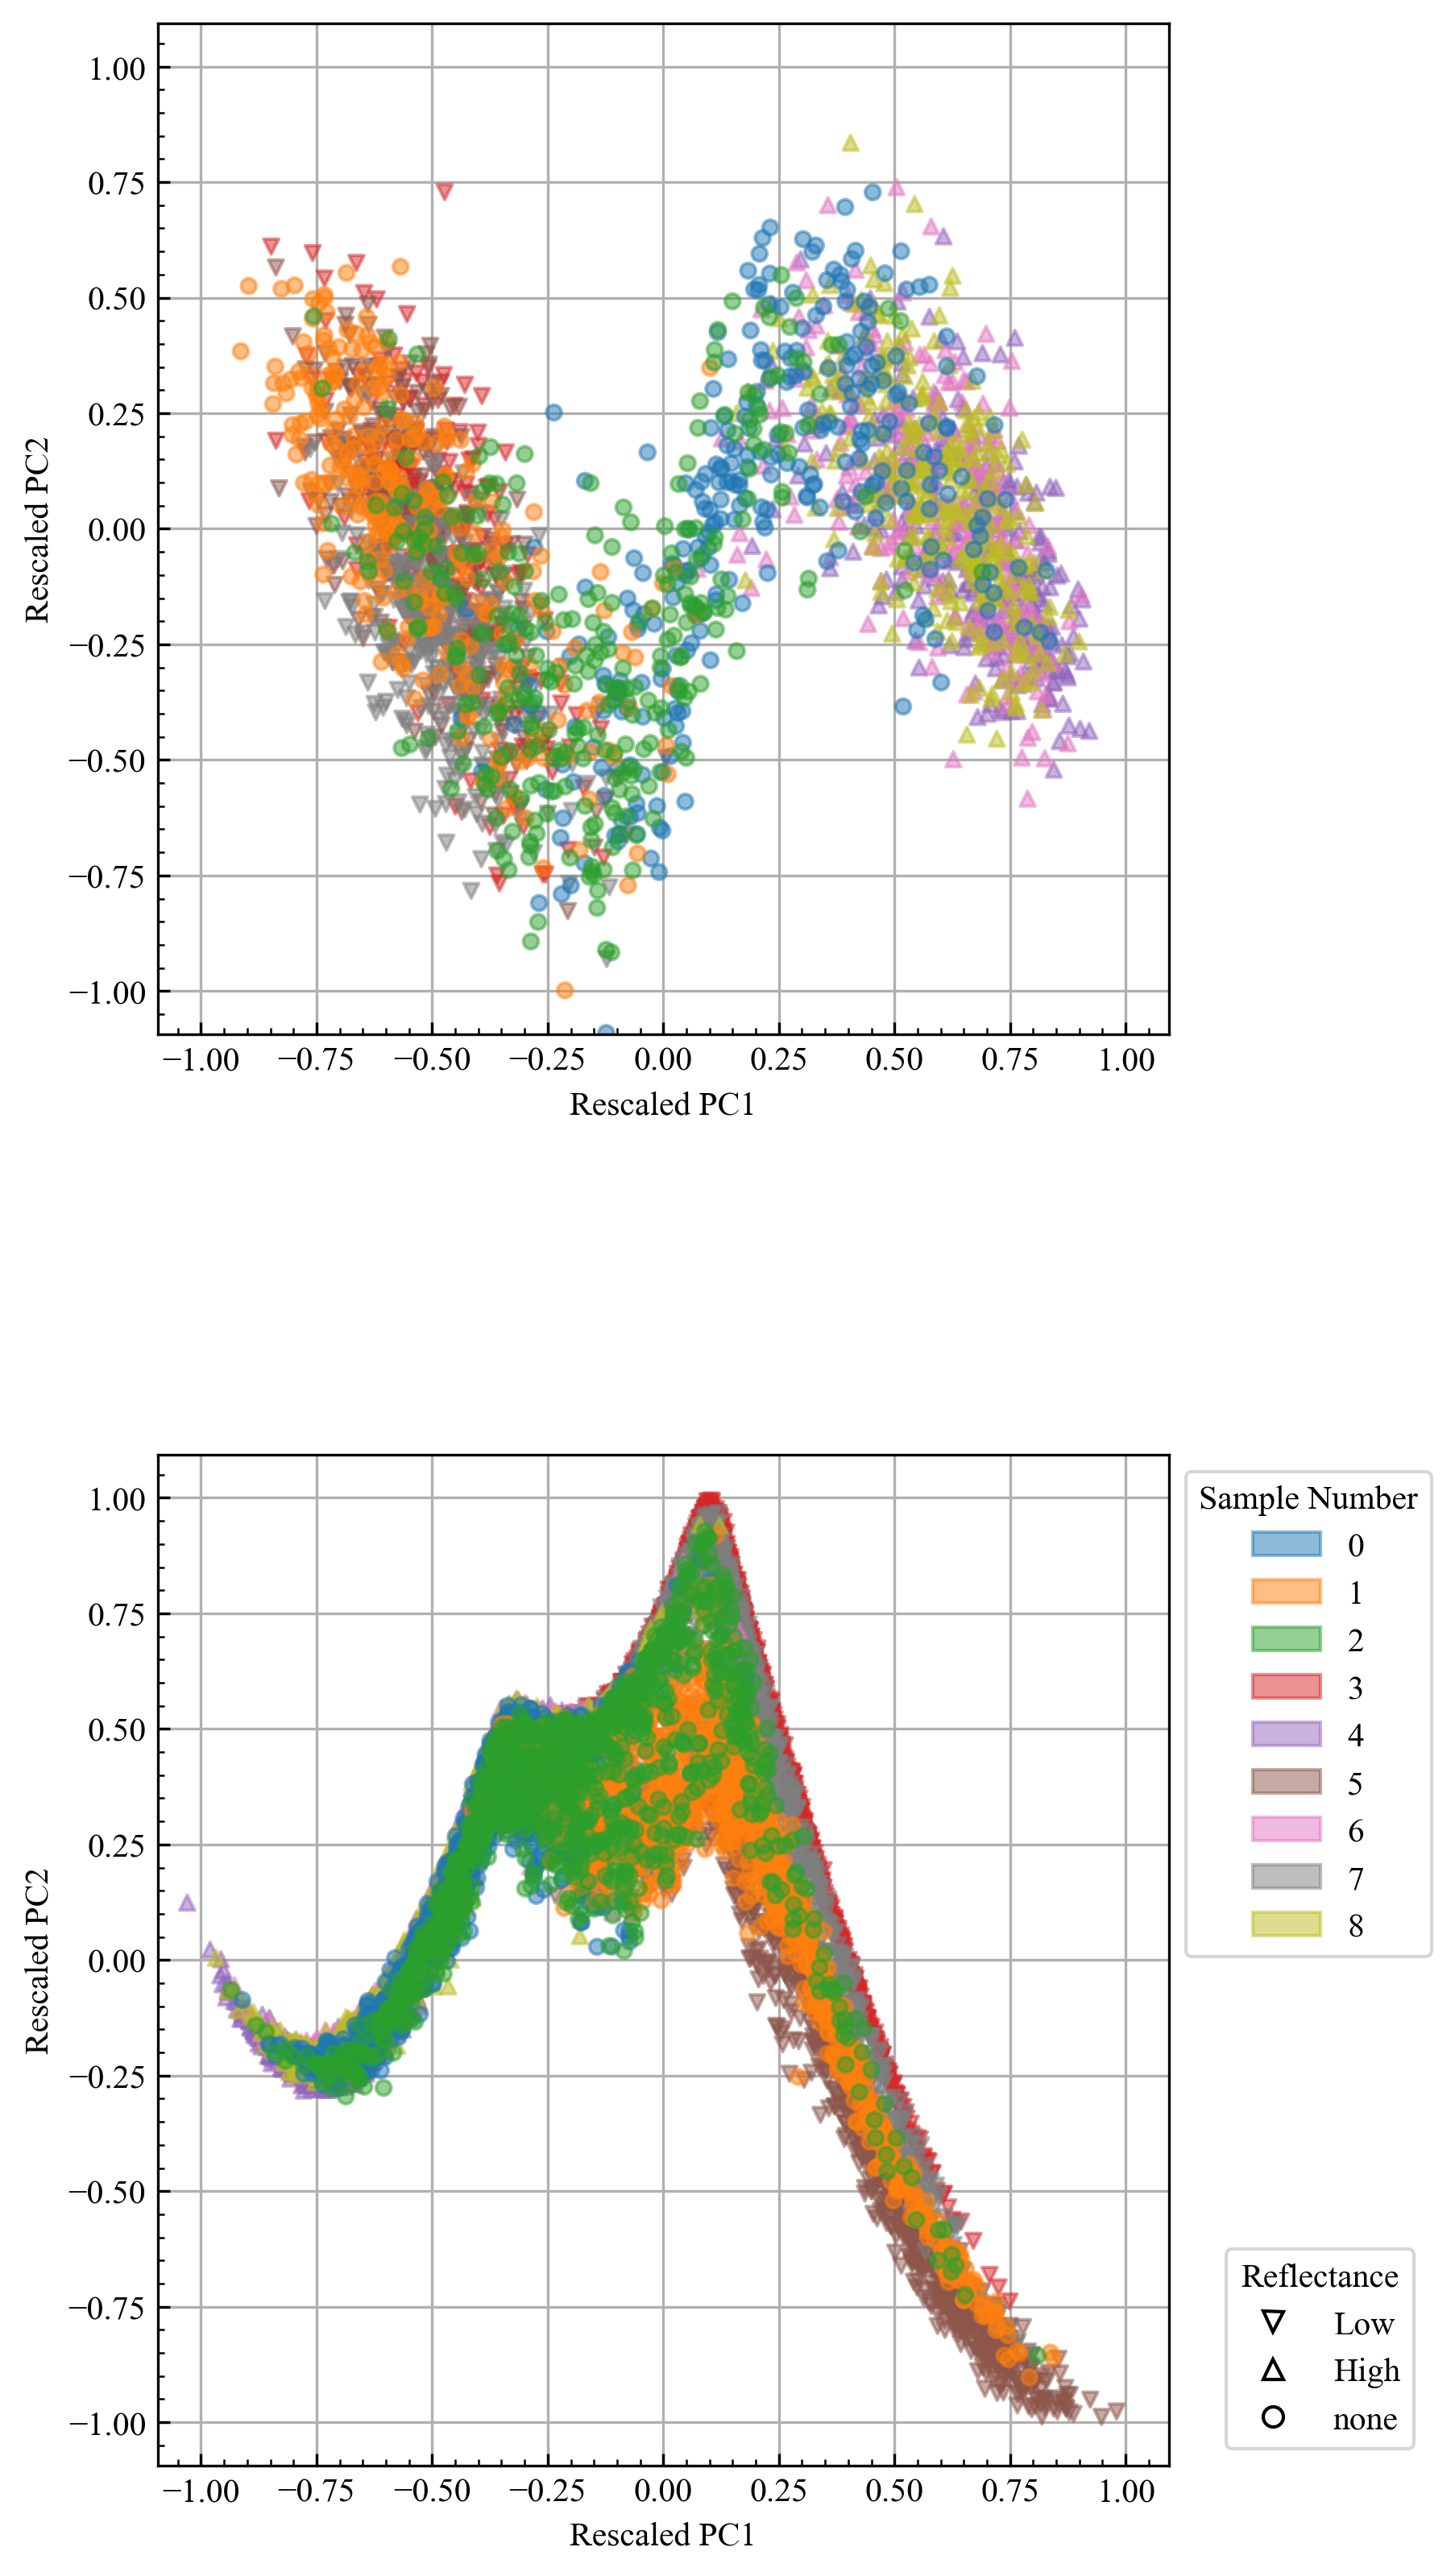

In [13]:
figsize = plot.cvt_unit((15, 30))
fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax64 = fig.add_subplot(2, 1, 1)
plot.plot_scatter_reflclsf_features(
    arr64_mm,
    metacheckdata64,
    ax=ax64,
    figsize_cm=(16, 16),
    plotting_dims=(0, 1),
    is_pca_data=True,
    is_rescaled_data=True,
    showing_legend=False,
)
plot.align_xy_ticks_interval(ax64)
ax32 = fig.add_subplot(2, 1, 2)
plot.plot_scatter_reflclsf_features(
    arr32_mm,
    metacheckdata32,
    ax=ax32,
    figsize_cm=(16, 16),
    plotting_dims=(0, 1),
    is_pca_data=True,
    is_rescaled_data=True,
    showing_legend=True,
)
ax_range = np.max([(ax.get_xlim(), ax.get_ylim()) for ax in (ax32, ax64)])
_ = [
    (ax.set_xlim(-ax_range, ax_range), ax.set_ylim(-ax_range, ax_range))
    for ax in (ax32, ax64)
]

In [6]:
checkdata32.groupby(pl.col("target")).agg(pl.col("dirname").unique().sort())

target,dirname
i64,list[i64]
0,"[3, 5, 7]"
1,"[4, 6, 8]"
-1,"[0, 1, 2]"


In [7]:
def plot_each_sample_dist(
    fig: Figure | None,
    axes: list[list[Axes]] | None,
    arrss: dict[int, dict[str, np.ndarray]],
    metadatas: dict[int, pl.DataFrame],
    refl_sample_id: dict[int, list[int]],
    pxsize: int,
    rescale_type: str,
    cmap: Colormap,
    markers: dict[int, MarkerType],
    s: float,
    alpha: float,
) -> list[list[Axes]]:
    if axes is None:
        axes = [
            [fig.add_subplot(3, 3, (3 * j) + i + 1) for i in range(3)]
            for j in range(3)
        ]

    axes_range: list[float] = []

    for (t, sample_ids), row_axes in zip(refl_sample_id.items(), axes):
        data = (
            metadatas[pxsize]
            .filter(pl.col("dirname").is_in(sample_ids))
            .sort(pl.col("dirname"))
        )
        sample_numbers = data.select("dirname").to_series().unique()
        for sample_number, col_ax in zip(sample_numbers, row_axes):
            sample_ids = (
                data.filter(pl.col("dirname") == sample_number)
                .select("id")
                .to_series()
            )
            col_ax.scatter(
                arrss[pxsize][rescale_type][sample_ids, 0],
                arrss[pxsize][rescale_type][sample_ids, 1],
                color=cmap(sample_number),
                s=s,
                alpha=alpha,
                marker=markers[t],
                label=f"target={t}, sampleID={sample_number}",
            )
            # axes_range.extend(
            #     (
            #         *col_ax.get_xlim(),
            #         *col_ax.get_ylim(),
            #     )
            # )
            col_ax.set_axisbelow(True)
            col_ax.set_aspect("equal")

    # max_xylim = np.max(axes_range)
    # for row_axes in axes:
    #     for col_ax in row_axes:
    #         col_ax.set_xlim(-max_xylim, max_xylim)
    #         col_ax.set_ylim(-max_xylim, max_xylim)
    #         # plot.align_xy_ticks_interval(col_ax)

    return axes

size: (240, 120)


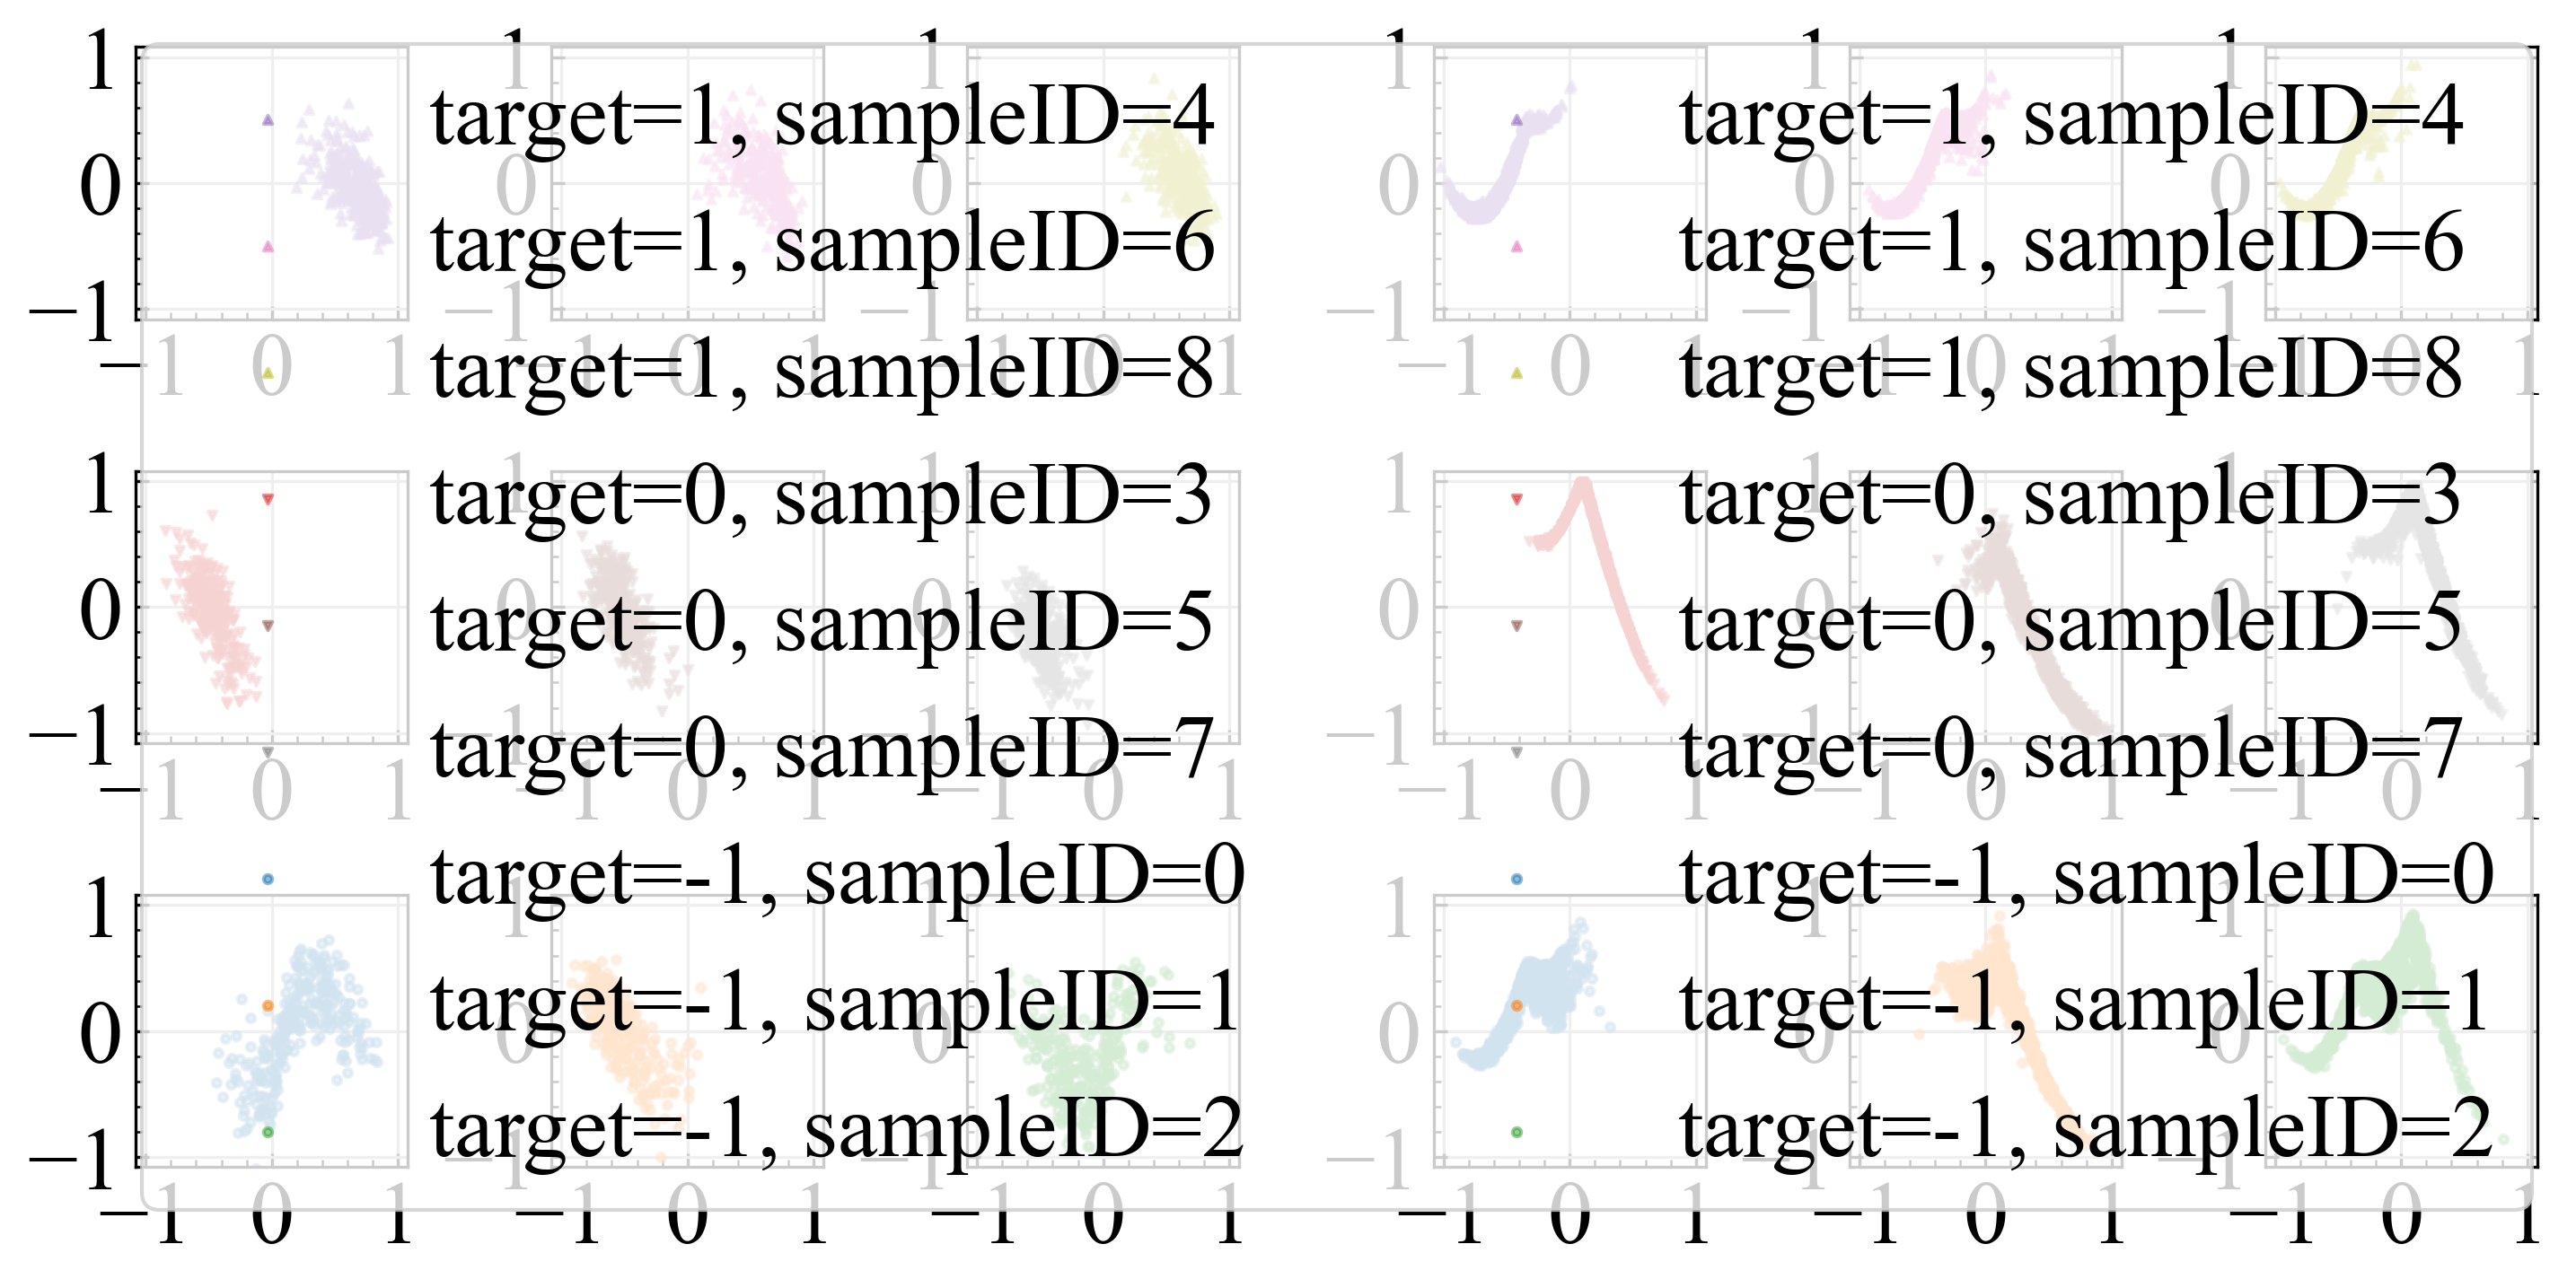

In [8]:
pxsize = 32
rescale_type = "mm"
axis_label = {
    "std": ("Component 1", "Component 2"),
    "pca": ("PC1", "PC2"),
    "mm": ("Rescaled PC1", "Rescaled PC2"),
}[rescale_type]
axis_numbers = (0, 1)
plot.set_mpl_styles(fontsize=24)

fig_aspect = (8, 4)
size = 30
figsize_mm = (fig_aspect[0] * size, fig_aspect[1] * size)
print(f"size: {figsize_mm}")

axis_range = None

refl_sample_id = {
    1: [4, 6, 8],
    0: [3, 5, 7],
    -1: [0, 1, 2],
}

figsize = plot.cvt_unit(figsize_mm, "mm")
fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
subfig = fig.subfigures(1, 2, wspace=0.04)
cmap = plt.get_cmap("tab10")
markers = {0: "v", 1: "^", -1: "o"}
metacheckdatas = {32: metacheckdata32, 64: metacheckdata64}
arrss = {32: arrs32, 64: arrs64}
subfig64: SubFigure = subfig[0]
subfig32: SubFigure = subfig[1]
subfig64.set_edgecolor("gray")
subfig32.set_edgecolor("gray")

axes64 = [
    [subfig64.add_subplot(3, 3, (3 * j) + i + 1) for i in range(3)]
    for j in range(3)
]
axes32 = [
    [subfig32.add_subplot(3, 3, (3 * j) + i + 1) for i in range(3)]
    for j in range(3)
]

plot_each_sample_dist(
    None,
    axes64,
    arrss,
    metacheckdatas,
    refl_sample_id,
    64,
    rescale_type,
    cmap,
    markers,
    s=5,
    alpha=0.5,
)
plot_each_sample_dist(
    None,
    axes32,
    arrss,
    metacheckdatas,
    refl_sample_id,
    32,
    rescale_type,
    cmap,
    markers,
    s=5,
    alpha=0.5,
)
all_axes = list(itertools.chain.from_iterable(axes64 + axes32))
xyaxis_aranges = np.array([(ax.get_xlim(), ax.get_ylim()) for ax in all_axes])
max_range = np.max(xyaxis_aranges)
_ = [
    (
        ax.set_xlim(-max_range, max_range),
        ax.set_ylim(-max_range, max_range),
        # ax.set_xlabel(axis_label[0]),
        # ax.set_ylabel(axis_label[1]),
    )
    for ax in all_axes
]

handle_label = [ax.get_legend_handles_labels() for ax in all_axes]
handles = list(itertools.chain.from_iterable([hl[0] for hl in handle_label]))
labels = list(itertools.chain.from_iterable([hl[1] for hl in handle_label]))
fig.legend(handles, labels, ncol=2)

figdir = Path("../reports/figures/ClassifierReflectance/thesis-ch4")
# fig.savefig(figdir / f"comp_pxsize_each_dist_rescale_{rescale_type}.svg")
# # fig.savefig(cfg64.figure_path / "scatter_plot_rescale_mm" / "each_sample_features.svg")

In [9]:
fig.savefig(figdir / f"comp_pxsize_each_dist_rescale_{rescale_type}_fntg.svg")

In [8]:
def hoge(
    metadata: pl.DataFrame,
    arrs: dict[str, np.array],
    ax: Axes,
    targets: pl.Series,
    rescale_type: str,
) -> list[PathCollection]:
    markers = {0: "v", 1: "^"}
    labels = {0: "Low", 1: "High"}
    colors = {0: (0, 0, 1, 0.3), 1: (1, 0, 0, 0.3)}
    pcs = []

    axis_label = {
        "std": ("Component 1", "Component 2"),
        "pca": ("PC1", "PC2"),
        "mm": ("Rescaled PC1", "Rescaled PC2"),
    }
    for t in targets:
        ll = (
            metadata.filter(pl.col("target") == t)
            .select("id")
            .to_series()
            .to_list()
        )
        _, pc = plot.plot_scatter(
            arrs[rescale_type][ll].T,
            ax,
            size=10,
            color=colors[t],
            marker=markers[t],
            ploting_axes=(0, 1),
            scatter_label=labels[t],
            axis_labels=axis_label[rescale_type],
        )
        pcs.append(pc)
    return pcs

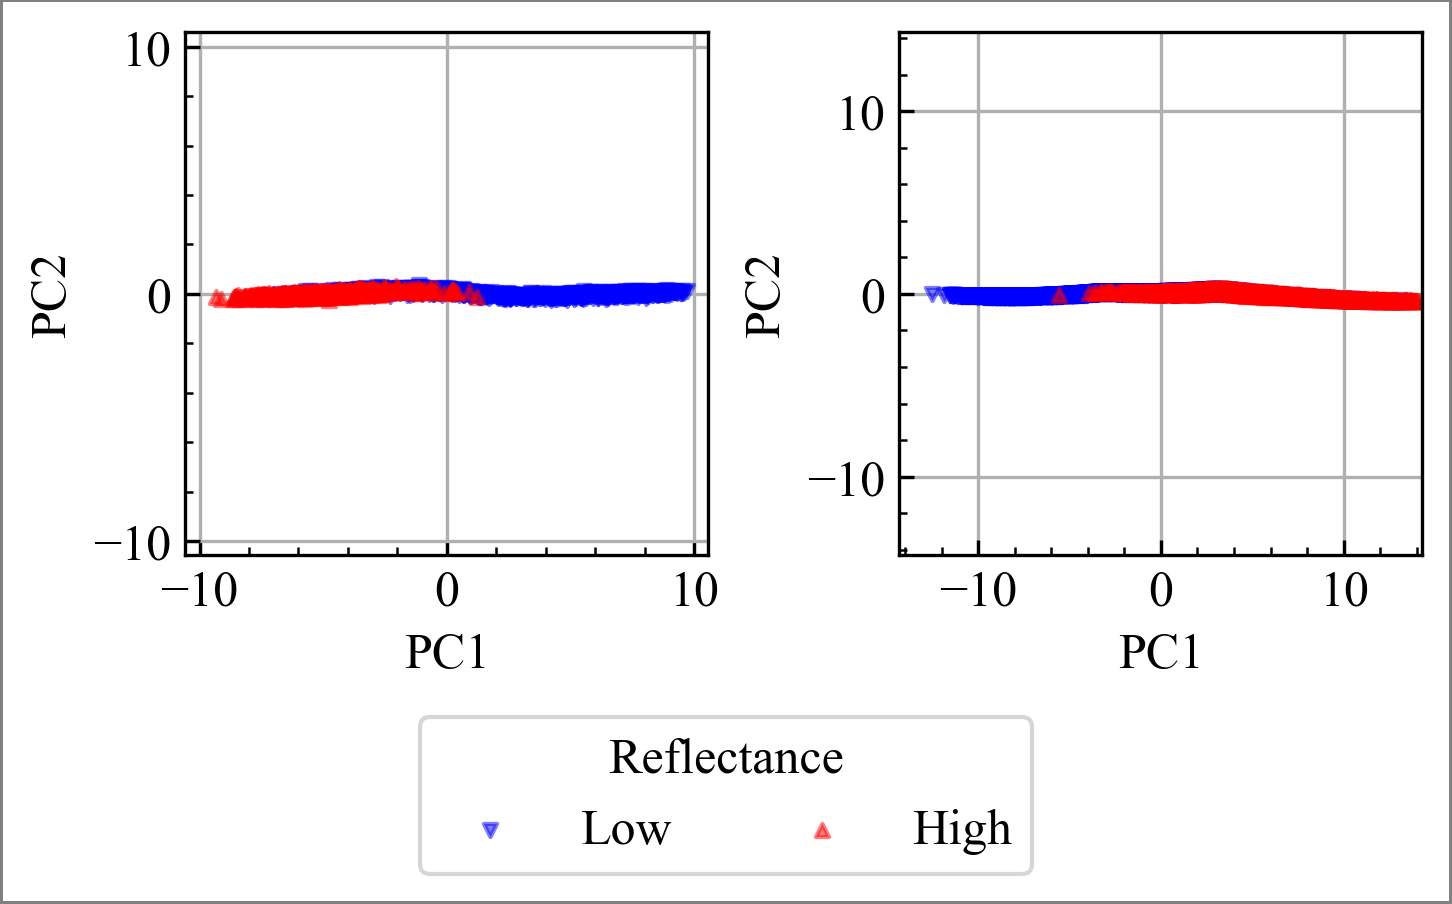

In [10]:
figsize_mm = (120, 60)
rescale_type = "pca"
targets64 = metacheckdata64.select("target").to_series().unique().sort()
targets32 = metacheckdata32.select("target").to_series().unique().sort()


figsize = plot.cvt_unit(figsize_mm, "mm")
fig = plt.figure(
    figsize=figsize,
    layout="constrained",
    dpi=300,
    linewidth=1,
    edgecolor="gray",
)

ax64 = fig.add_subplot(1, 2, 1)
hoge(metacheckdata64, arrs64, ax64, targets64, rescale_type)
ax64.set_axisbelow(True)
plot._align_xy_ticks_interval(ax64)

ax32 = fig.add_subplot(1, 2, 2)
hoge(metacheckdata32, arrs32, ax32, targets32, rescale_type)
ax32.set_axisbelow(True)
plot._align_xy_ticks_interval(ax32)

handles, labels = ax32.get_legend_handles_labels()

# handle = ax32.legend()
fig.legend(
    handles=handles,
    labels=labels,
    title="Reflectance",
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
)
# fig.savefig(cfg64.figure_path.parent/f"dist_comp_pca_80mm.svg")

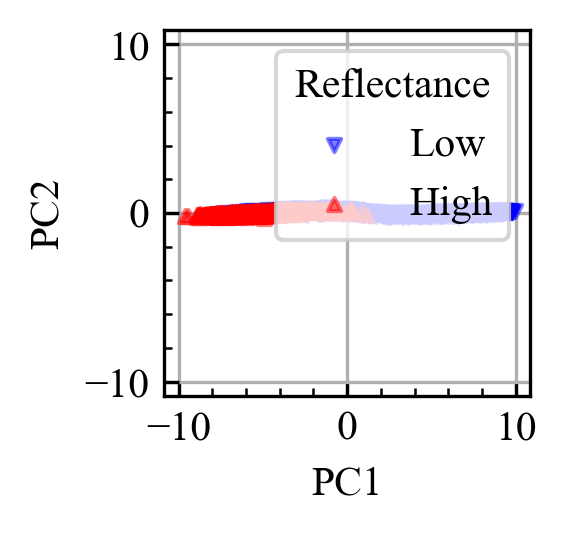

In [25]:
mm = 45
figsize = plot.cvt_unit((mm, mm), "mm")
targets = metacheckdata64.select("target").to_series().unique().sort()
markers = {0: "v", 1: "^"}
labels = {0: "Low", 1: "High"}
colors = {0: (0, 0, 1, 0.3), 1: (1, 0, 0, 0.3)}
rescale_type = "pca"

axis_label = {
    "std": ("Component 1", "Component 2"),
    "pca": ("PC1", "PC2"),
    "mm": ("Rescaled PC1", "Rescaled PC2"),
}

fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax = fig.add_subplot()
for t in targets:
    ll = (
        metacheckdata64.filter(pl.col("target") == t)
        .select("id")
        .to_series()
        .to_list()
    )
    plot.plot_scatter(
        arrs64[rescale_type][ll].T,
        ax,
        size=10,
        color=colors[t],
        marker=markers[t],
        ploting_axes=(0, 1),
        scatter_label=labels[t],
        axis_labels=axis_label[rescale_type],
    )

ax.legend(title="Reflectance")
ax.set_axisbelow(True)

figsave_dir = cfg64.figure_path / f"scatter_plot_rescale_{rescale_type}"
if not figsave_dir.exists():
    figsave_dir.mkdir(parents=True)

for ext in plot.IMG_EXT:
    fig.savefig(figsave_dir / f"feature64_{mm}mm.{ext}")

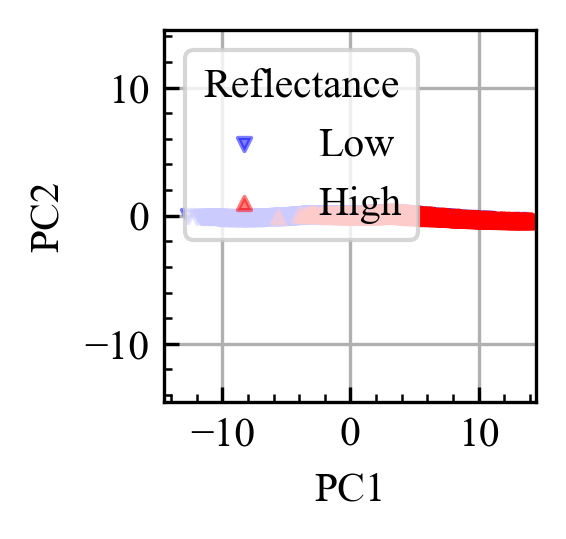

In [29]:
mm = 45
figsize = plot.cvt_unit((mm, mm), old="mm")
targets = metadata32.select("target").to_series().unique().sort()
markers = {0: "v", 1: "^"}
labels = {0: "Low", 1: "High"}
colors = {0: (0, 0, 1, 0.3), 1: (1, 0, 0, 0.3)}
rescale_type = "pca"

axis_label = {
    "std": ("Component 1", "Component 2"),
    "pca": ("PC1", "PC2"),
    "mm": ("Rescaled PC1", "Rescaled PC2"),
}

fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax = fig.add_subplot()
for t in targets:
    ll = (
        metadata32.filter(pl.col("target") == t)
        .select("id")
        .to_series()
        .to_list()
    )
    plot.plot_scatter(
        arrs32[rescale_type][ll].T,
        ax,
        size=10,
        color=colors[t],
        marker=markers[t],
        scatter_label=labels[t],
        axis_labels=axis_label[rescale_type],
    )

ax.legend(title="Reflectance")
ax.set_axisbelow(True)

figsave_dir = cfg32.figure_path / f"scatter_plot_rescale_{rescale_type}"
if not figsave_dir.exists():
    figsave_dir.mkdir(parents=True)

for ext in plot.IMG_EXT:
    fig.savefig(figsave_dir / f"feature32_{mm}mm.{ext}")

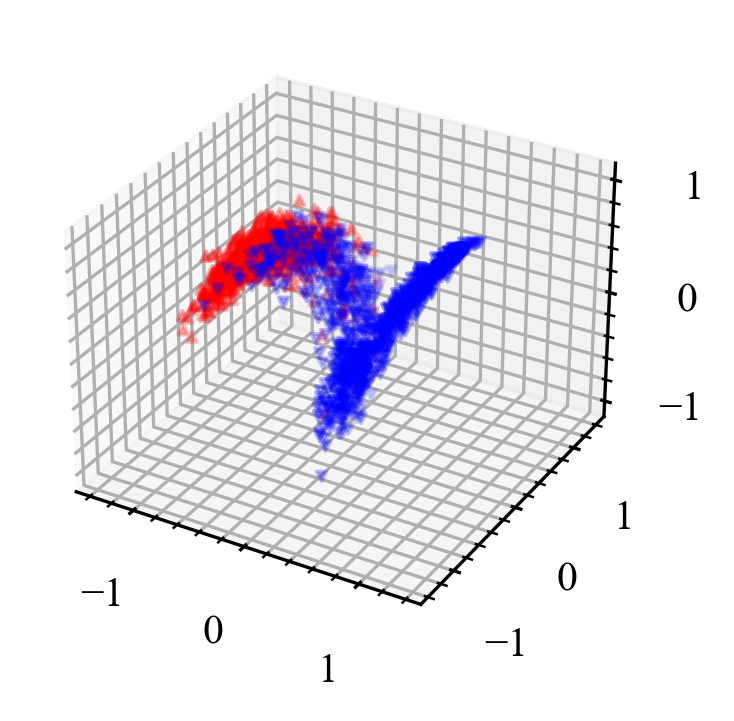

In [11]:
rescale_type = "mm"
alpha = 0.4

figsize = plot.cvt_unit((6, 6))
targets = metadata64.select("target").to_series().unique().sort()
markers = {0: "v", 1: "^"}
labels = {0: "Low", 1: "High"}
colors = {0: (0, 0, 1, alpha), 1: (1, 0, 0, alpha)}

axis_label = {
    "std": ("Component 1", "Component 2"),
    "pca": ("PC1", "PC2"),
    "mm": ("Rescaled PC1", "Rescaled PC2"),
}
view_range: list[float] = []
fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax: Axes3D = fig.add_subplot(projection="3d")
for t in targets:
    ll = (
        metadata64.filter(pl.col("target") == t)
        .select("id")
        .to_series()
        .to_list()
    )
    arr = arrs64[rescale_type][ll]
    ax.scatter(
        arr[:, 0],
        arr[:, 1],
        arr[:, 2],
        s=5,
        color=colors[t],
        marker=markers[t],
    )
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    z_range = ax.get_zlim()
    view_range.extend((*x_range, *y_range, *z_range))

plot_range = np.max(np.abs(view_range))


# plot.plot_scatter(
#     arrs64[rescale_type][ll].T,
#     ax,
#     color=colors[t],
#     marker=markers[t],
#     ploting_axes=(1,2),
#     scatter_label=labels[t],
#     axis_labels=axis_label[rescale_type]
# )
ax.set_xlim(-plot_range, plot_range)
ax.set_ylim(-plot_range, plot_range)
ax.set_zlim(-plot_range, plot_range)
ax.zaxis.minorticks_on()
ax.axis("equal")

ax.set_axisbelow(True)

# figsave_dir = cfg64.figure_path / f"scatter_plot_rescale_{rescale_type}"
# if not figsave_dir.exists():
#     figsave_dir.mkdir(parents=True)

# for ext in plot.IMG_EXT:
#     fig.savefig(figsave_dir / f"feature64.{ext}")

In [61]:
clsf_failed_data32 = metacheckdata32.filter(
    (pl.col("target") != -1) & (pl.col("target") != pl.col("prediction"))
)
clsf_failed_data32.filter(pl.col("target") == 0)

id,target,prediction,dirname,filename
u32,i64,i64,i64,str
15,0,1,3,"""10k_3_h000_w04…"
16,0,1,3,"""10k_3_h000_w05…"
39,0,1,3,"""10k_3_h000_w12…"
51,0,1,3,"""10k_3_h032_w03…"
131,0,1,3,"""10k_3_h096_w03…"
135,0,1,3,"""10k_3_h096_w04…"
139,0,1,3,"""10k_3_h096_w06…"
148,0,1,3,"""10k_3_h096_w08…"
157,0,1,3,"""10k_3_h096_w11…"
